In [2]:
# XGBoost without SMOTE and using scale_pos_weight to manage the unbalanced dataset
# The scale_pos_weight parameter serves to give more "weight" to errors made on the minority class (1) during training.

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

df = pd.read_csv("../data/train.csv")

# 🔹 features / target
X = df.drop(columns=['id', 'target'])
y = df['target']

# 🔹 Column identification
binary_cols = [col for col in X.columns if '_bin' in col]
categorical_cols = [col for col in X.columns if '_cat' in col]
numeric_cols = [col for col in X.columns if col not in binary_cols + categorical_cols]

# 🔹 Preprocessing
preprocessor = ColumnTransformer([
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols)
], remainder="passthrough")

# 🔹 Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 🔹 Calcolate scale_pos_weight
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = neg / pos

In [3]:
# 🔹 Pipeline with XGBoost
clf = Pipeline([
    ("preprocessing", preprocessor),
    ("xgb", XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42
    ))
])

# 🔹 Training
clf.fit(X_train, y_train)

# 🔹 Assessment
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred))

print("\n🎯 ROC-AUC Score:", round(roc_auc_score(y_test, y_proba), 4))

c:\Users\robin\Desktop\Bootcamp_Files\group-ml-porto-seguro\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:56:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📊 Confusion Matrix:
[[73383 41321]
 [ 1911  2428]]

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.64      0.77    114704
           1       0.06      0.56      0.10      4339

    accuracy                           0.64    119043
   macro avg       0.52      0.60      0.44    119043
weighted avg       0.94      0.64      0.75    119043


🎯 ROC-AUC Score: 0.6391


Perfect — now we can do a **side-by-side comparison** of **Model 1 (0.54 recall) vs Model 2 (the winning model above)** 🚀

---

## 🔍 Key Differences

| Aspect                             | **Model 1**                                                                                                                                              | **Model 2**                                                                                                                                                              |
| ---------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **Feature Encoding**               | Uses `LabelEncoder` on categorical columns → each category is turned into a single integer (can mislead the model into thinking categories are ordered). | Uses `OneHotEncoder` inside a `ColumnTransformer` → expands categorical features into dummy variables, which is generally **better** for tree-based models like XGBoost. |
| **Preprocessing Integration**      | Preprocessing happens **outside** the model pipeline.                                                                                                    | Preprocessing is **wrapped in a `Pipeline`** with the model, so transformations are applied consistently at training and testing.                                        |
| **scale\_pos\_weight calculation** | Computed **after** defining the model (bug in code order — `scale_pos_weight` is undefined when passed).                                                 | Correctly computed **before model creation**, using only the training set (which avoids data leakage).                                                                   |
| **max\_depth**                     | 5                                                                                                                                                        | 4                                                                                                                                                                        |
| **Workflow**                       | Manual: you preprocess, then split, then fit. Risk of forgetting preprocessing at inference.                                                             | End-to-end: pipeline ensures preprocessing + model are tied together → safer in production.                                                                              |
| **Flexibility**                    | Simpler, but less modular.                                                                                                                               | More maintainable and extensible (e.g. easy to add scalers, imputers).                                                                                                   |
| **Risk of Data Leakage**           | Higher, since `LabelEncoder` is fit before the split.                                                                                                    | Lower, since encoders are fit only on training data inside the pipeline.                                                                                                 |

---

## 🏆 Which is Better?

* **Model 2** is more **robust and production-ready**:

  * Proper preprocessing with a `Pipeline`.
  * Correct handling of categorical variables (`OneHotEncoder`).
  * Prevents data leakage by fitting encoders only on training data.
* **Model 1** is a simpler, more manual approach that works for prototyping but has pitfalls (especially the bug with `scale_pos_weight` order).

---

👉 In short:

* **Model 1** = Quick & dirty, risks leakage, weaker categorical encoding.
* **Model 2** = Clean, pipeline-based, safer for deployment.

---

Do you want me to **fix Model 1** so that it’s structured like Model 2 (pipeline, correct order, but still using your LabelEncoder idea)? That way you’d have two comparable, clean versions.


## Visualization of the model

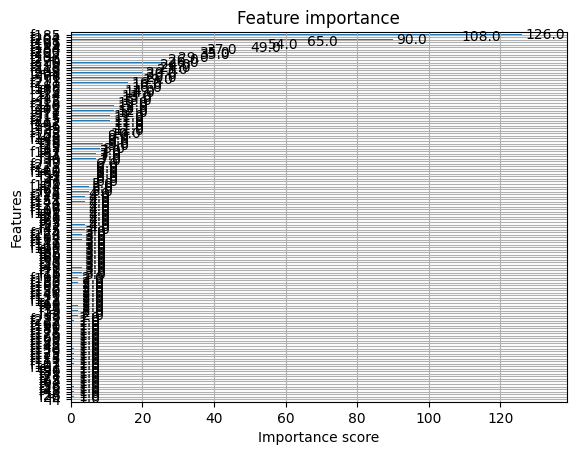

In [6]:
from xgboost import plot_importance


xgb_model = clf.named_steps["xgb"]
plot_importance(xgb_model, importance_type="weight")  # "weight", "gain", or "cover"
plt.show()


<Figure size 800x600 with 0 Axes>

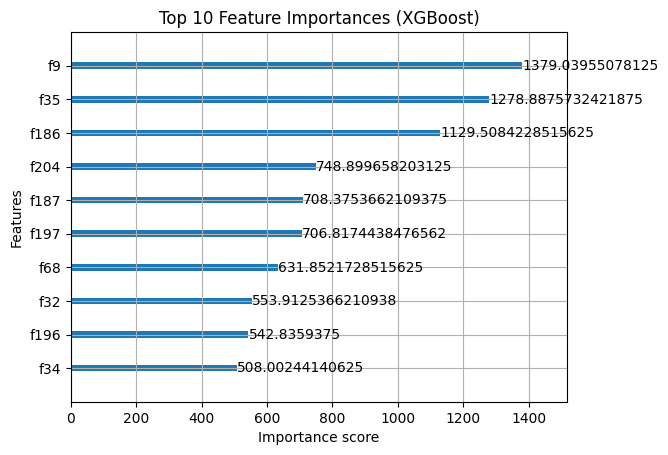

In [13]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot only the top 10 features by importance
plt.figure(figsize=(8,6))
plot_importance(xgb_model, importance_type="gain", max_num_features=10)
plt.title("Top 10 Feature Importances (XGBoost)")
plt.show()
